In [64]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from sklearn.preprocessing import PolynomialFeatures
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,BananaShape
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q,test_traj
from optimize import Run_eval_test,optimize_parallel_new 
from utils import *
import copy

In [65]:
def H(k, x):
    if k==0:
        return 1.0
    if k ==1:
        return x
    if k==2:
        return (x**2 - 1)/np.sqrt(2)
    c = np.zeros(k+1,dtype = float)
    c[k] = 1.0
    h = P.hermite_e.hermeval(x,c) / np.sqrt(sp.special.factorial(k)) 
    return h

def compute_H(k,x):
    return H(k[0],x[:,0])*H(k[1],x[:,1])

In [66]:
def approx_q(X_train,Y_train,N_traj_train,lag,max_deg):
    """
    Function to regress q functions on a polynomial basis;
    Args:
        X_train - train tralectory;
        Y_train - function values;
        N_traj_train - number of training trajectories;
        lag - truncation point for coefficients, those for |p-l| > lag are set to 0;
        max_deg - maximum degree of polynomial in regression
    """
    dim = X_train[0,:].shape[0]
    #print("dimension = ",dim)
    coefs_poly = np.array([])
    for i in range(lag):
        x_all = np.array([])
        y_all = np.array([])
        for j in range(N_traj_train):
            y = Y_train[j,i:,0]
            if i == 0:
                x = X_train[j,:]
            else:
                x = X_train[j,:-i]
            #concatenate results
            if x_all.size == 0:
                x_all = x
            else:
                x_all = np.concatenate((x_all,x),axis = 0)
            y_all = np.concatenate([y_all,y])
        #should use polyfeatures here
        #print("variance: ",np.var(y_all))
        #print(y_all[:50])
        poly = PolynomialFeatures(max_deg)
        X_features = poly.fit_transform(x_all)
        #print(X_features.shape)
        lstsq_results = np.linalg.lstsq(X_features,y_all,rcond = None)
        coefs = copy.deepcopy(lstsq_results[0])
        coefs.resize((1,X_features.shape[1]))           
        if coefs_poly.size == 0:
            coefs_poly = copy.deepcopy(coefs)
        else:
            coefs_poly = np.concatenate((coefs_poly,coefs),axis=0)
    return coefs_poly

In [67]:
def test_traj(coefs_poly_regr,gamma,r_seed,lag,d,N_test,x0):
    """
    function to perform 2-dimensional martingale decomposition
    """
    X_test,Noise = generate_traj(x0,N_test,gamma,r_seed,d)
    test_stat_vanilla = np.zeros(N_test,dtype = float)
    test_stat_vr = np.zeros_like(test_stat_vanilla)
    #compute number of basis polynomials
    basis_funcs = np.array([[1,0],[0,1],[1,1],[2,0],[0,2]])
    num_basis_funcs = len(basis_funcs)
    #compute polynomials of noise variables Z_l
    poly_vals = np.zeros((num_basis_funcs,N_test), dtype = float)
    for k in range(len(basis_funcs)):
        poly_vals[k,:] = compute_H(basis_funcs[k],Noise)
    #initialize function
    f_vals_vanilla = np.sum(X_test,axis=1)
    #array to store control variates values
    cvfs = np.zeros_like(f_vals_vanilla)
    #compute coeffitients bar_a
    bar_a_0_1 = np.zeros((lag,N_test),dtype=float)
    bar_a_1_0 = np.zeros_like(bar_a_0_1)
    bar_a_1_1 = np.zeros_like(bar_a_0_1)
    bar_a_2_0 = np.zeros_like(bar_a_0_1)
    bar_a_0_2 = np.zeros_like(bar_a_0_1)
    for i in range(lag):
        #coefficients with H_0_1
        bar_a_0_1[i,1:] = coefs_poly_regr[i,2]*np.sqrt(2*gamma)+\
                        2*coefs_poly_regr[i,5]*np.sqrt(2*gamma)*(X_test[:-1]+gamma*b(X_test[:-1]))[:,1]+\
                        coefs_poly_regr[i,4]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,0]*np.sqrt(2*gamma)
        bar_a_0_1[i,0] = coefs_poly_regr[i,2]*np.sqrt(2*gamma)+\
                        2*coefs_poly_regr[i,5]*np.sqrt(2*gamma)*(x0 + gamma*b(x0))[1]+\
                        coefs_poly_regr[i,4]*(x0 + gamma*b(x0))[0]*np.sqrt(2*gamma)
        #coefficients with H_1_0
        bar_a_1_0[i,1:] = coefs_poly_regr[i,1]*np.sqrt(2*gamma)+\
                        coefs_poly_regr[i,4]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,1]*np.sqrt(2*gamma)+\
                        2*coefs_poly_regr[i,3]*np.sqrt(2*gamma)*(X_test[:-1]+gamma*b(X_test[:-1]))[:,0]
        bar_a_1_0[i,0] = coefs_poly_regr[i,1]*np.sqrt(2*gamma)+\
                        coefs_poly_regr[i,4]*(x0 + gamma*b(x0))[1]*np.sqrt(2*gamma)+\
                        2*coefs_poly_regr[i,3]*np.sqrt(2*gamma)*(x0 + gamma*b(x0))[1]
        #second-order coefficients
        #coefficients with H_1_1
        bar_a_1_1[i,:] = 2*coefs_poly_regr[i,4]*gamma
        #coefficients with H_2_0
        bar_a_2_0[i,1:] = 2*np.sqrt(2)*coefs_poly_regr[i,3]*gamma
        #coefficients with H_0_2
        bar_a_0_2[i,1:] = 2*np.sqrt(2)*coefs_poly_regr[i,5]*gamma
    bar_a_1_0 = bar_a_1_0*poly_vals[0,:]
    bar_a_0_1 = bar_a_0_1*poly_vals[1,:]
    bar_a_1_1 = bar_a_1_1*poly_vals[2,:]
    bar_a_2_0 = bar_a_2_0*poly_vals[3,:]
    bar_a_0_2 = bar_a_0_2*poly_vals[4,:]
    #compute martingale sums
    M_n_0_1 = 0.0
    M_n_1_0 = 0.0
    M_n_1_1 = 0.0
    M_n_2_0 = 0.0
    M_n_0_2 = 0.0
    for l in range(N_test):
        for r in range(min(N_test-l,lag)):
            M_n_0_1 += bar_a_0_1[r,l]
            M_n_1_0 += bar_a_1_0[r,l]
            M_n_1_1 += bar_a_1_1[r,l]
            M_n_2_0 += bar_a_2_0[r,l]
            M_n_0_2 += bar_a_0_2[r,l]
    #print("M_n_0_1: ",M_n_0_1)
    #print("M_n_1_0: ",M_n_1_0)
    return np.mean(f_vals_vanilla), np.mean(f_vals_vanilla)-(M_n_0_1 + M_n_1_0 + M_n_1_1)/N_test, np.mean(f_vals_vanilla)-(M_n_0_1 + M_n_1_0 + M_n_1_1 + M_n_2_0 + M_n_0_2)/N_test
#
#
#

In [68]:
def b(X_t):
    """
    b function in the diffusion
    """
    #normal case
    return -X_t

def sample_discretized_diffusion(X_t,gamma_t,d):
    """
    args:   X_t - current value, 
            gamma_t - step size;
            d - dimension;
            cov - covariance matrix
    returns:  (X_{t+1},xi_{t+1}) - value at the next time moment and the corresponding noise variable
    """
    xi = np.random.randn(d)
    return X_t + gamma_t*b(X_t) + np.sqrt(2*gamma_t)*xi,xi

#currently we use this function without the burn-in
def generate_traj(x0,n,gamma,r_seed,d):
    """
    args:
        x0 - starting point;
        n - number of steps;
        gamma - step size (assumed to be fixed for now);
    returns:
        x_all,noise_all - np.arrays of shape (n,)  
    """
    x_all = np.zeros((n,d),dtype = float)
    noise_all = np.zeros((n,d),dtype = float)
    np.random.seed(r_seed)
    x_all[0],noise_all[0] = sample_discretized_diffusion(x0,gamma,d)
    for i in range(1,n):
        x_all[i],noise_all[i] = sample_discretized_diffusion(x_all[i-1],gamma,d)
    return x_all,noise_all

In [69]:
#lags = np.array([10,20,30,40,50,60,70,80,90,100])
lags = np.array([2,4,6,8,10,12,14,16,18,20])
vr_rates = []

In [70]:
n = 5*10**4 #sample size
gamma = 2e-1 # Step size
n_traj = 1
d = 2

n_traj_test = 100 # Number of independent MCMC trajectories for test
f_type = "linear"
K_max = 2 #max degree of Hermite polynomial
S_max = 2 #max degree of polynomial during regression stage
lag = 100 #maximal lag order
N_test = 5*10**4

In [71]:
x0 = np.array([0.0,0.0],dtype = float)
r_seed = 1812
X_train, noise_train = generate_traj(x0,n,gamma,r_seed,d)
#set target function
if f_type == "quadratic":
    Y_train = np.sum(X_train**2,axis=1)
elif f_type == "linear":
    Y_train = np.sum(X_train,axis=1)
X_train = X_train.reshape((1,-1,d))
Y_train = Y_train.reshape((1,-1,1))

### Bernoulli:: Optimize coefficients by solving regression with polynomial features

In [72]:
#polynomial coefficients
coefs_poly = approx_q(X_train,Y_train,n_traj,lag,S_max)
#print(coefs_poly.shape)
print(coefs_poly)
regr_vals = np.zeros((lag,X_train.shape[1]),dtype=float)
features = np.zeros((X_train.shape[1],6),dtype=float)
features[:,0] = 1.0
features[:,1:3] = X_train[0,:,:]
features[:,3] = X_train[0,:,0]**2 
features[:,4] = X_train[0,:,0]*X_train[0,:,1]
features[:,5] = X_train[0,:,1]**2
for i in range(len(regr_vals)):
    regr_vals[i,:] = np.sum(coefs_poly[i,:]*features,axis=1)

[[-1.69156805e-16  1.00000000e+00  1.00000000e+00 -6.75677115e-17
  -3.08567126e-16 -9.88387005e-17]
 [ 2.20212327e-03  8.00291061e-01  8.06113625e-01  1.55752108e-03
  -1.22444554e-04 -1.72441594e-03]
 [ 1.09402906e-03  6.43111391e-01  6.54172646e-01 -2.16956088e-04
  -5.58579043e-03  2.40643269e-03]
 [ 3.00760726e-03  5.15409142e-01  5.32947800e-01 -9.94463385e-04
  -4.79914217e-03  2.57094788e-03]
 [-2.85336440e-03  4.14440463e-01  4.27153753e-01  2.42939511e-03
  -6.86410780e-03  5.38224058e-03]
 [-3.49005929e-03  3.29186543e-01  3.40833045e-01  6.27759312e-03
  -4.71802473e-03  2.93098299e-03]
 [-1.57412596e-03  2.63189205e-01  2.70785350e-01  8.01335222e-03
   1.32971737e-04  1.06142826e-04]
 [ 4.83517971e-03  2.13257729e-01  2.16290888e-01  6.44322643e-03
   2.54299623e-03 -3.56546423e-03]
 [ 6.85095976e-03  1.72795499e-01  1.73676193e-01  5.20403996e-03
   7.08610684e-03 -3.79861161e-03]
 [ 7.05639719e-03  1.41476583e-01  1.37567501e-01  4.59530649e-03
   5.56218678e-03 -3.0090

Test regression

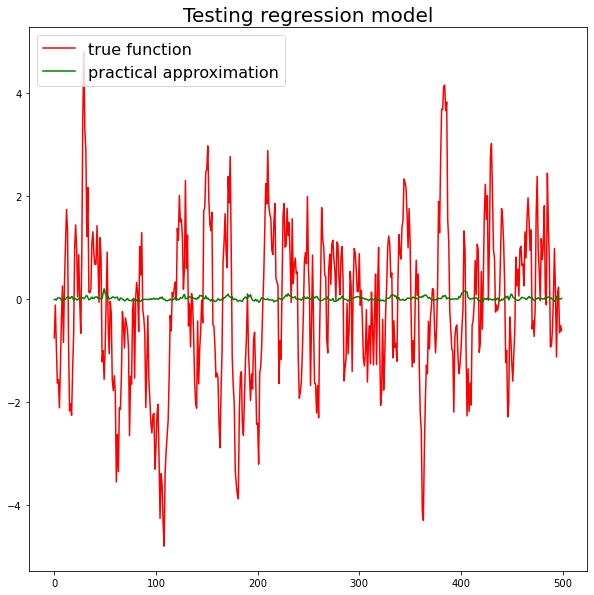

In [73]:
cur_lag = 20
N_pts = 500
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(Y_train[0,cur_lag:N_pts+cur_lag,0],color='r',label='true function')
plt.plot(regr_vals[cur_lag,:N_pts],color='g',label = 'practical approximation')
plt.legend(loc = 'upper left',fontsize = 16)
plt.show()

In [74]:
test_seed = 1453
res_list = []
for cur_lag in lags:
    nbcores = multiprocessing.cpu_count()
    trav = Pool(nbcores)
    res = trav.starmap(test_traj, [(coefs_poly,gamma,test_seed+i,cur_lag,d,N_test,x0) for i in range (n_traj_test)])
    #res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
    trav.close()
    res_list.append(np.asarray(res))

In [75]:
res_list = np.asarray(res_list)
print(res_list.shape)

(10, 100, 3)


### Comparison boxplots

In [76]:
title = ""
labels = ['Vanilla\n ULA', 'ULA \nwith MDCV-1', 'ULA \nwith MDCV-2']

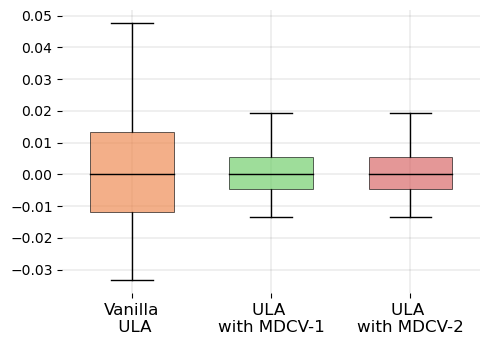

In [77]:
ind=1
data = [res_list[ind,:,0],res_list[ind,:,1], res_list[ind,:,2]] 
boxplot_ind(data, title, labels,path="./2d_gaussian_linear_cost_01_12.pdf")

In [78]:
var_arr = np.var(res_list,axis=1)
print(var_arr.shape)

(10, 3)


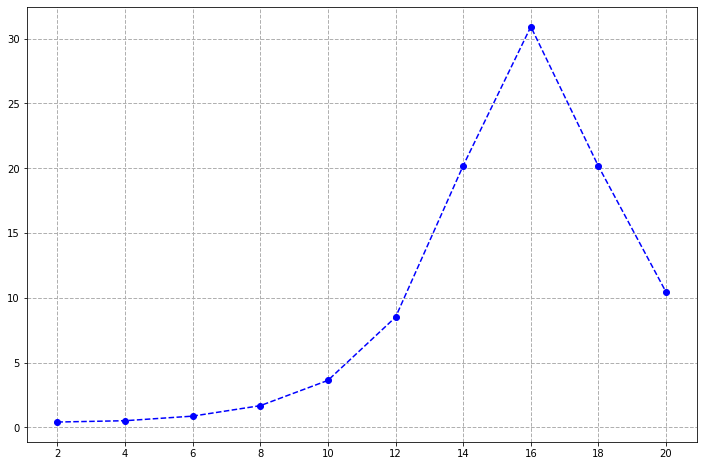

In [79]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0, 21, 2)
ax.set_xticks(major_ticks)
# plot the index for the x-values
#plt.plot(lags,vr_rates_dep/(lags*8), marker='o', linestyle='--', color='r', label='Train on dependent trajectories') 
plt.plot(lags,(var_arr[:,0]/var_arr[:,1])/(lags*3), marker='o', linestyle='--', color='b') #,label='Train on independent trajectories') 
#plt.xlabel('lag',fontsize = 18)
#plt.ylabel('cost',fontsize = 18) 
#plt.title('VR cost for MDCV, Gaussian distribution, quadratic target',fontsize = 20)
plt.grid(linestyle='--', linewidth=1.0)
#plt.legend() 
#plt.show()
plt.savefig("./2d_gaussian_linear_cost_01_12.pdf")

In [ ]:
plt.figure(figsize=(12,8))
# plot the index for the x-values
#plt.plot(lags[:8],vr_rates_dep, marker='o', linestyle='--', color='r', label='Train on dependent trajectories') 
plt.plot(lags[:8],vr_rates_indep, marker='o', linestyle='--', color='b', label='Train on independent trajectories') 
#plt.xlabel('lag',fontsize = 18)
#plt.ylabel('VR rate',fontsize = 18) 
#plt.title('VR rates for MDCV, Gaussian Mixture, quadratic target',fontsize = 20)
plt.grid(linestyle='--', linewidth=1.0)
plt.legend() 
plt.show()